In [145]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from sklearn.metrics import balanced_accuracy_score as BACC
from sklearn.model_selection import train_test_split
import eval_scores as eval
import cv2 as cv
import random

In [146]:
def augment_data(xtrain, ytrain):
    print(xtrain.shape, ytrain.shape)
    #(6470, 50, 50) (6470,)
    #(50, 50) ()
    xtrain_len = len(xtrain)
    
    aug_xtrain = np.zeros((xtrain_len*2, 50, 50))
    aug_ytrain = np.zeros((xtrain_len*2))
    
    aug_xtrain[0:xtrain_len, :, :] = xtrain
    aug_ytrain[0:xtrain_len] = ytrain
    
    for idx in range(xtrain_len):
        image = xtrain[idx,:,:]
        label = ytrain[idx]
                
        angle = int(random.uniform(-90, 90))
        h, w = image.shape[0], image.shape[1]
        M = cv.getRotationMatrix2D((int(w/2), int(h/2)), angle, 1)
        rotated = cv.warpAffine(image, M, (w, h))
        
        flipped = cv.flip(rotated, 1)


        aug_xtrain[xtrain_len+idx] = flipped
        aug_ytrain[xtrain_len+idx] = label
        
        
    return aug_xtrain, aug_ytrain

In [147]:
xtrain = np.load("Xtrain_Classification_Part1.npy")
ytrain = np.load("Ytrain_Classification_Part1.npy")
xtrain_len = len(xtrain)
ytrain_len = len(ytrain)

#Reshape Images
xtrain = xtrain.reshape((xtrain_len,50,50))
mean = xtrain.mean(axis=(0, 1, 2)) 
std = xtrain.std(axis=(0, 1, 2))

xtrain = (xtrain - mean)/std  

xtrain, ytrain = augment_data(xtrain, ytrain)

(6470, 50, 50) (6470,)


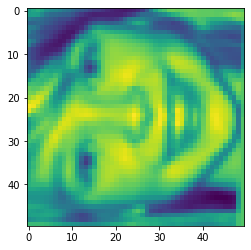

In [148]:
plt.imshow(xtrain[6479,:,:])
plt.show()

In [178]:
class ImageDataset(Dataset):
    def __init__(self):
        xtrain = np.load("Xtrain_Classification_Part1.npy")
        ytrain = np.load("Ytrain_Classification_Part1.npy")
        xtest = np.load("Xtest_Classification_Part1.npy")


        xtrain_len = len(xtrain)
        ytrain_len = len(ytrain)
        xtest_len = len(xtest)

        #Reshape Images
        xtrain = xtrain.reshape((xtrain_len,50,50))
        mean = xtrain.mean(axis=(0, 1, 2)) 
        std = xtrain.std(axis=(0, 1, 2))

        xtrain = (xtrain - mean)/std  
        
        xtrain, ytrain = augment_data(xtrain, ytrain)
        
        new_xtrain_len = len(xtrain)
        new_ytrain_len = len(ytrain)
        
        self.xtrain = xtrain.reshape((new_xtrain_len,1,50,50))
        self.xtest = xtest.reshape((xtest_len,1,50,50))

        self.ytrain = ytrain.reshape(new_ytrain_len)

    def __len__(self):
        return len(self.xtest)

    def __getitem__(self, idx):
 
        
        image = self.xtest[idx, :, :, :]
        label = self.ytrain[idx]
        

        return image, label
    

In [172]:
class TestImageDataset(Dataset):
    def __init__(self):
        xtest = np.load("Xtest_Classification_Part1.npy")


        xtest_len = len(xtest)


        self.xtest = xtest.reshape((xtest_len,1,50,50))


    def __len__(self):
        return len(self.xtest)

    def __getitem__(self, idx):

        
        image = self.xtest[idx, :, :, :]
        

        return image
    

In [150]:
class ClassifyNet(nn.Module):

    def __init__(self):
        super(ClassifyNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=3,
                              kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(in_channels=5, out_channels=10,
                              kernel_size=5, stride=1)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(in_features=2500, out_features=400)
        self.fc2 = nn.Linear(in_features=1587, out_features=1)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)
        
        #x = self.conv2(x)
        #x = F.relu(x)
        #x = F.max_pool2d(x, 2, 2)
        
        #print(x.shape)
        
        x = x.view(x.shape[0], -1)
        
        x = self.dropout(x)
        
        #print(x.shape)
        
        #x = self.fc1(x)
        #x = F.relu(x)
        
        #x = self.dropout(x)
        
        x = self.fc2(x)
        x = torch.sigmoid(x)
                
        return x

In [151]:
config = {
    'batch_size' : 64,
    'lr' : 0.001,
    'momentum' : 0.9
}

In [152]:
def train_model(model):
    
    num_epochs = 400
    best_score = 1.0
    
    for epoch in range(num_epochs):
        
        model.train()
        running_loss = 0.0
        
        criterion = nn.BCELoss()
        
        for idx, data in enumerate(train_loader):
            image, label = data[0].float().to(device), data[1].float()
            
            
            optimizer.zero_grad()
            
            classify_output = model(image)
            
            
            y_true = torch.reshape(label.cpu(), (-1,))
            y_pred = torch.reshape(classify_output.cpu(), (-1,))
            
            loss = criterion(y_pred, y_true)

            #print(loss)

            loss.backward()
            optimizer.step()
            
            # print for mini batches
            running_loss += loss.item()
            if idx % 50 == 49:  # every 50 mini batches
                print('[Epoch %d, %5d Mini Batches] loss: %.3f' %
                      (epoch + 1, idx + 1, running_loss/50))
                running_loss = 0.0
               
        model.eval()
        test_score = 0.0
        
         
        with torch.no_grad():
            for idx, data in enumerate(test_loader):
                image, label = data[0].float().to(device), data[1].float()

                classify_output = model(image)

                y_true = torch.reshape(label.cpu(), (-1,))
                y_pred = torch.reshape(classify_output.cpu(), (-1,))

                test_loss = criterion(y_pred, y_true)

                test_score += test_loss

            test_score /= len(test_loader)

            print(test_score)

            if test_score < best_score:
                torch.save(model, "ClassifyNet.pth")
                best_score = test_score
        

In [153]:
data_set = ImageDataset()

train_set, test_set = train_test_split(data_set, test_size=0.2, random_state=1, shuffle=True)

train_loader = DataLoader(train_set, batch_size=config['batch_size'], shuffle=True)
test_loader = DataLoader(test_set, batch_size=config['batch_size'], shuffle=True)

(6470, 50, 50) (6470,)


In [154]:
torch.cuda.empty_cache()

In [155]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device= torch.device('cpu')
model = ClassifyNet().to(device)

optimizer = optim.SGD(model.parameters(), lr=config['lr'], momentum=config['momentum'])

In [156]:
train_model(model)

[Epoch 1,    50 Mini Batches] loss: 0.644
[Epoch 1,   100 Mini Batches] loss: 0.600
[Epoch 1,   150 Mini Batches] loss: 0.580
tensor(0.5505)
[Epoch 2,    50 Mini Batches] loss: 0.563
[Epoch 2,   100 Mini Batches] loss: 0.555
[Epoch 2,   150 Mini Batches] loss: 0.553
tensor(0.5226)
[Epoch 3,    50 Mini Batches] loss: 0.544
[Epoch 3,   100 Mini Batches] loss: 0.525
[Epoch 3,   150 Mini Batches] loss: 0.538
tensor(0.4989)
[Epoch 4,    50 Mini Batches] loss: 0.511
[Epoch 4,   100 Mini Batches] loss: 0.521
[Epoch 4,   150 Mini Batches] loss: 0.517
tensor(0.4869)
[Epoch 5,    50 Mini Batches] loss: 0.510
[Epoch 5,   100 Mini Batches] loss: 0.508
[Epoch 5,   150 Mini Batches] loss: 0.486
tensor(0.4740)
[Epoch 6,    50 Mini Batches] loss: 0.492
[Epoch 6,   100 Mini Batches] loss: 0.499
[Epoch 6,   150 Mini Batches] loss: 0.489
tensor(0.4725)
[Epoch 7,    50 Mini Batches] loss: 0.492
[Epoch 7,   100 Mini Batches] loss: 0.489
[Epoch 7,   150 Mini Batches] loss: 0.487
tensor(0.4677)
[Epoch 8,    

[Epoch 58,   100 Mini Batches] loss: 0.419
[Epoch 58,   150 Mini Batches] loss: 0.422
tensor(0.4124)
[Epoch 59,    50 Mini Batches] loss: 0.401
[Epoch 59,   100 Mini Batches] loss: 0.423
[Epoch 59,   150 Mini Batches] loss: 0.421
tensor(0.4152)
[Epoch 60,    50 Mini Batches] loss: 0.420
[Epoch 60,   100 Mini Batches] loss: 0.420
[Epoch 60,   150 Mini Batches] loss: 0.411
tensor(0.4096)
[Epoch 61,    50 Mini Batches] loss: 0.413
[Epoch 61,   100 Mini Batches] loss: 0.418
[Epoch 61,   150 Mini Batches] loss: 0.419
tensor(0.4124)
[Epoch 62,    50 Mini Batches] loss: 0.406
[Epoch 62,   100 Mini Batches] loss: 0.421
[Epoch 62,   150 Mini Batches] loss: 0.429
tensor(0.4180)
[Epoch 63,    50 Mini Batches] loss: 0.419
[Epoch 63,   100 Mini Batches] loss: 0.414
[Epoch 63,   150 Mini Batches] loss: 0.414
tensor(0.4091)
[Epoch 64,    50 Mini Batches] loss: 0.410
[Epoch 64,   100 Mini Batches] loss: 0.425
[Epoch 64,   150 Mini Batches] loss: 0.415
tensor(0.4166)
[Epoch 65,    50 Mini Batches] loss

tensor(0.4089)
[Epoch 115,    50 Mini Batches] loss: 0.406
[Epoch 115,   100 Mini Batches] loss: 0.405
[Epoch 115,   150 Mini Batches] loss: 0.411
tensor(0.4074)
[Epoch 116,    50 Mini Batches] loss: 0.410
[Epoch 116,   100 Mini Batches] loss: 0.412
[Epoch 116,   150 Mini Batches] loss: 0.405
tensor(0.4101)
[Epoch 117,    50 Mini Batches] loss: 0.414
[Epoch 117,   100 Mini Batches] loss: 0.415
[Epoch 117,   150 Mini Batches] loss: 0.396
tensor(0.4048)
[Epoch 118,    50 Mini Batches] loss: 0.413
[Epoch 118,   100 Mini Batches] loss: 0.398
[Epoch 118,   150 Mini Batches] loss: 0.395
tensor(0.4092)
[Epoch 119,    50 Mini Batches] loss: 0.423
[Epoch 119,   100 Mini Batches] loss: 0.394
[Epoch 119,   150 Mini Batches] loss: 0.392
tensor(0.4064)
[Epoch 120,    50 Mini Batches] loss: 0.391
[Epoch 120,   100 Mini Batches] loss: 0.416
[Epoch 120,   150 Mini Batches] loss: 0.408
tensor(0.4105)
[Epoch 121,    50 Mini Batches] loss: 0.402
[Epoch 121,   100 Mini Batches] loss: 0.404
[Epoch 121,   1

[Epoch 171,    50 Mini Batches] loss: 0.400
[Epoch 171,   100 Mini Batches] loss: 0.405
[Epoch 171,   150 Mini Batches] loss: 0.399
tensor(0.4111)
[Epoch 172,    50 Mini Batches] loss: 0.412
[Epoch 172,   100 Mini Batches] loss: 0.389
[Epoch 172,   150 Mini Batches] loss: 0.410
tensor(0.4080)
[Epoch 173,    50 Mini Batches] loss: 0.403
[Epoch 173,   100 Mini Batches] loss: 0.394
[Epoch 173,   150 Mini Batches] loss: 0.405
tensor(0.4087)
[Epoch 174,    50 Mini Batches] loss: 0.418
[Epoch 174,   100 Mini Batches] loss: 0.396
[Epoch 174,   150 Mini Batches] loss: 0.398
tensor(0.4130)
[Epoch 175,    50 Mini Batches] loss: 0.387
[Epoch 175,   100 Mini Batches] loss: 0.413
[Epoch 175,   150 Mini Batches] loss: 0.399
tensor(0.4121)
[Epoch 176,    50 Mini Batches] loss: 0.381
[Epoch 176,   100 Mini Batches] loss: 0.418
[Epoch 176,   150 Mini Batches] loss: 0.390
tensor(0.4106)
[Epoch 177,    50 Mini Batches] loss: 0.403
[Epoch 177,   100 Mini Batches] loss: 0.406
[Epoch 177,   150 Mini Batches

[Epoch 227,    50 Mini Batches] loss: 0.408
[Epoch 227,   100 Mini Batches] loss: 0.402
[Epoch 227,   150 Mini Batches] loss: 0.392
tensor(0.4082)
[Epoch 228,    50 Mini Batches] loss: 0.387
[Epoch 228,   100 Mini Batches] loss: 0.400
[Epoch 228,   150 Mini Batches] loss: 0.397
tensor(0.4104)
[Epoch 229,    50 Mini Batches] loss: 0.393
[Epoch 229,   100 Mini Batches] loss: 0.393
[Epoch 229,   150 Mini Batches] loss: 0.407
tensor(0.4121)
[Epoch 230,    50 Mini Batches] loss: 0.392
[Epoch 230,   100 Mini Batches] loss: 0.395
[Epoch 230,   150 Mini Batches] loss: 0.391
tensor(0.4084)
[Epoch 231,    50 Mini Batches] loss: 0.379
[Epoch 231,   100 Mini Batches] loss: 0.395
[Epoch 231,   150 Mini Batches] loss: 0.405
tensor(0.4162)
[Epoch 232,    50 Mini Batches] loss: 0.395
[Epoch 232,   100 Mini Batches] loss: 0.386
[Epoch 232,   150 Mini Batches] loss: 0.400
tensor(0.4139)
[Epoch 233,    50 Mini Batches] loss: 0.402
[Epoch 233,   100 Mini Batches] loss: 0.400
[Epoch 233,   150 Mini Batches

[Epoch 283,    50 Mini Batches] loss: 0.389
[Epoch 283,   100 Mini Batches] loss: 0.379
[Epoch 283,   150 Mini Batches] loss: 0.408
tensor(0.4126)
[Epoch 284,    50 Mini Batches] loss: 0.398
[Epoch 284,   100 Mini Batches] loss: 0.391
[Epoch 284,   150 Mini Batches] loss: 0.394
tensor(0.4140)
[Epoch 285,    50 Mini Batches] loss: 0.388
[Epoch 285,   100 Mini Batches] loss: 0.406
[Epoch 285,   150 Mini Batches] loss: 0.376
tensor(0.4163)
[Epoch 286,    50 Mini Batches] loss: 0.375
[Epoch 286,   100 Mini Batches] loss: 0.390
[Epoch 286,   150 Mini Batches] loss: 0.397
tensor(0.4161)
[Epoch 287,    50 Mini Batches] loss: 0.383
[Epoch 287,   100 Mini Batches] loss: 0.404
[Epoch 287,   150 Mini Batches] loss: 0.408
tensor(0.4115)
[Epoch 288,    50 Mini Batches] loss: 0.388
[Epoch 288,   100 Mini Batches] loss: 0.383
[Epoch 288,   150 Mini Batches] loss: 0.406
tensor(0.4163)
[Epoch 289,    50 Mini Batches] loss: 0.392
[Epoch 289,   100 Mini Batches] loss: 0.394
[Epoch 289,   150 Mini Batches

[Epoch 339,    50 Mini Batches] loss: 0.396
[Epoch 339,   100 Mini Batches] loss: 0.395
[Epoch 339,   150 Mini Batches] loss: 0.396
tensor(0.4144)
[Epoch 340,    50 Mini Batches] loss: 0.389
[Epoch 340,   100 Mini Batches] loss: 0.408
[Epoch 340,   150 Mini Batches] loss: 0.396
tensor(0.4121)
[Epoch 341,    50 Mini Batches] loss: 0.404
[Epoch 341,   100 Mini Batches] loss: 0.387
[Epoch 341,   150 Mini Batches] loss: 0.399
tensor(0.4116)
[Epoch 342,    50 Mini Batches] loss: 0.394
[Epoch 342,   100 Mini Batches] loss: 0.396
[Epoch 342,   150 Mini Batches] loss: 0.395
tensor(0.4134)
[Epoch 343,    50 Mini Batches] loss: 0.377
[Epoch 343,   100 Mini Batches] loss: 0.390
[Epoch 343,   150 Mini Batches] loss: 0.413
tensor(0.4142)
[Epoch 344,    50 Mini Batches] loss: 0.389
[Epoch 344,   100 Mini Batches] loss: 0.391
[Epoch 344,   150 Mini Batches] loss: 0.397
tensor(0.4152)
[Epoch 345,    50 Mini Batches] loss: 0.391
[Epoch 345,   100 Mini Batches] loss: 0.397
[Epoch 345,   150 Mini Batches

KeyboardInterrupt: 

In [190]:

test_set = ImageDataset()
print(len(train_set))

test_loader = DataLoader(test_set, batch_size=1, shuffle=False)


(6470, 50, 50) (6470,)
1164


In [194]:
# Test model against training data

model = torch.load("ClassifyNet.pth")

predictions = np.zeros((len(test_set)))

output = []
with torch.no_grad():
    for idx, data in enumerate(test_loader):
        image = data[0].float().to(device)
        classify_output = model(image)
    
        y_pred = (torch.reshape(classify_output.cpu(), (-1,)) > 0.5).numpy()
        
        predictions[idx] = y_pred



In [196]:
predictions.


array([0., 0., 1., ..., 0., 0., 1.])